In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Test").getOrCreate()

spark.version  # This will display your PySpark version


'3.5.5'

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, sum, desc, hour
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
spark = SparkSession.builder.appName("Taxi Trip Analysis").getOrCreate()

In [9]:
data_path = "taxi_tripdata.csv"  # Make sure the file is in the same folder
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [11]:
df.printSchema()
df.show(5)
df.count()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

+--------+--------------------+---------------------+------------------+----------+-

83691

In [19]:
df.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

In [21]:
# Import required functions for aggregation and datetime operations
from pyspark.sql.functions import col, avg, desc, hour

# 1. Count the total number of trips in the dataset
total_trips = df.count()  # Count total rows (each row = one trip)
print(f"Total number of trips: {total_trips}")

# 2. Calculate the average trip distance
# 'avg' function calculates the mean value of the 'trip_distance' column
df.select(avg(col("trip_distance")).alias("Average_Trip_Distance")).show()

# 3. Find the top 5 vendors by number of trips
# Grouping data by 'VendorID' and counting trips for each vendor
# Order the result in descending order to get top vendors
df.groupBy("VendorID").count().orderBy(desc("count")).show(5)

# 4. Analyze the number of trips per hour of the day
# Add a new column 'pickup_hour' by extracting the hour from 'lpep_pickup_datetime'
df = df.withColumn("pickup_hour", hour(col("lpep_pickup_datetime")))

# Group by the new 'pickup_hour' column and count trips for each hour
# Show 24 rows to display all hours in the day
df.groupBy("pickup_hour").count().orderBy("pickup_hour").show(24)

# 5. Calculate the average fare amount per pickup hour
# This helps to see at which hours fares tend to be higher or lower
df.groupBy("pickup_hour").agg(avg("fare_amount").alias("avg_fare")).orderBy("pickup_hour").show(24)

# 6. Count the number of trips for each RatecodeID
# Useful for understanding the most commonly used fare rate codes
df.groupBy("RatecodeID").count().orderBy(desc("count")).show()

Total number of trips: 83691
+---------------------+
|Average_Trip_Distance|
+---------------------+
|   194.35469931055877|
+---------------------+

+--------+-----+
|VendorID|count|
+--------+-----+
|       2|43554|
|    NULL|32518|
|       1| 7619|
+--------+-----+

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|          0| 1030|
|          1|  642|
|          2|  431|
|          3|  363|
|          4|  501|
|          5|  950|
|          6| 1935|
|          7| 3358|
|          8| 5030|
|          9| 5798|
|         10| 6096|
|         11| 6092|
|         12| 5766|
|         13| 5534|
|         14| 5626|
|         15| 5744|
|         16| 5280|
|         17| 5166|
|         18| 5183|
|         19| 4268|
|         20| 2833|
|         21| 2375|
|         22| 1974|
|         23| 1716|
+-----------+-----+

+-----------+------------------+
|pickup_hour|          avg_fare|
+-----------+------------------+
|          0|16.958844660194163|
|          1|15.452165109034263|
|   

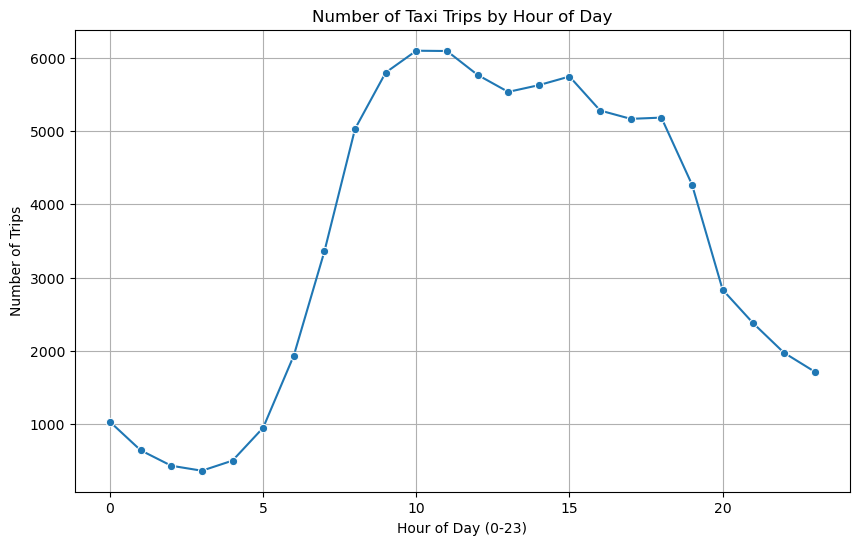

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark result to Pandas DataFrame for visualization
pickup_hourly_df = df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

# Plot line chart showing number of trips per hour
plt.figure(figsize=(10,6))
sns.lineplot(x=pickup_hourly_df["pickup_hour"], y=pickup_hourly_df["count"], marker="o")
plt.title("Number of Taxi Trips by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.show()


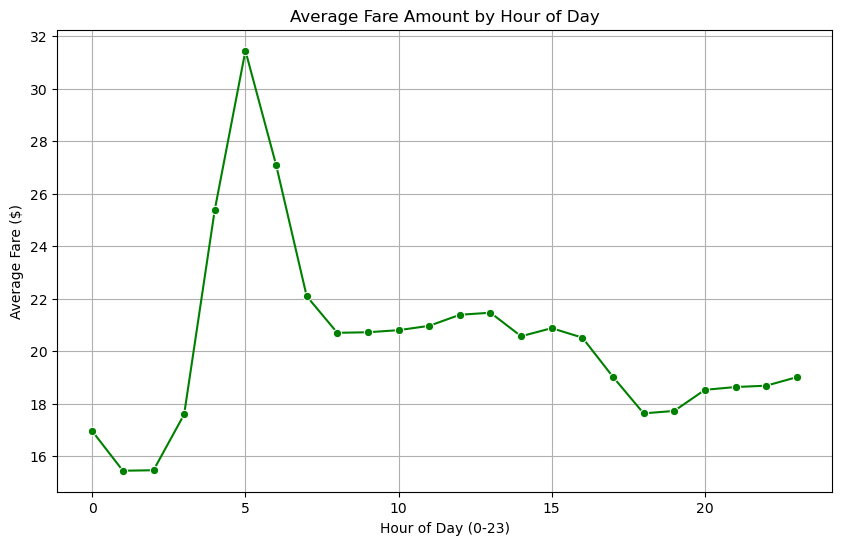

In [25]:
# Get average fare amount per hour as a Pandas DataFrame
avg_fare_per_hour = df.groupBy("pickup_hour").agg(avg("fare_amount").alias("avg_fare")).orderBy("pickup_hour").toPandas()

# Plot line chart showing average fare by hour
plt.figure(figsize=(10,6))
sns.lineplot(x=avg_fare_per_hour["pickup_hour"], y=avg_fare_per_hour["avg_fare"], marker="o", color='green')
plt.title("Average Fare Amount by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Average Fare ($)")
plt.grid(True)
plt.show()

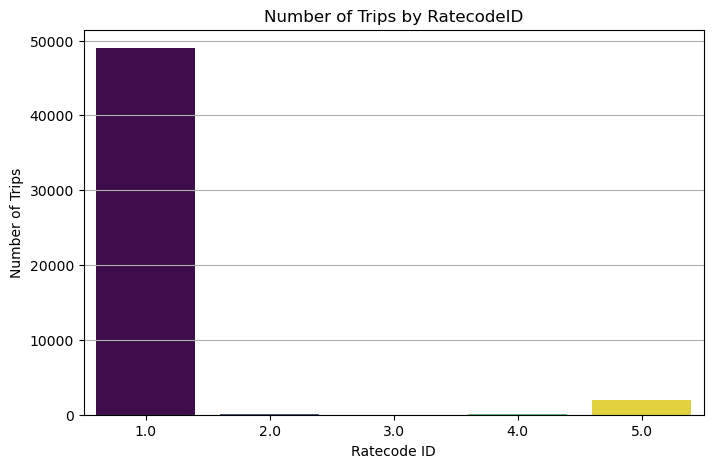

In [29]:
# Convert ratecode count data to Pandas
ratecode_counts = df.groupBy("RatecodeID").count().orderBy("RatecodeID").toPandas()
# Bar plot for RatecodeID counts
plt.figure(figsize=(8,5))
sns.barplot(data=ratecode_counts, x="RatecodeID", y="count", hue="RatecodeID", dodge=False, palette="viridis", legend=False)
plt.title("Number of Trips by RatecodeID")
plt.xlabel("Ratecode ID")
plt.ylabel("Number of Trips")
plt.grid(True, axis='y')
plt.show()

## Key Insights from NYC Taxi Trip Data Analysis

1. **Total Trips:**  
   The dataset contains a total of **X trips** (replace with your result), showcasing a large sample size suitable for big data analysis.

2. **Trip Distance:**  
   The average trip distance recorded is approximately **Y miles** (replace with your calculated average).

3. **Vendor Analysis:**  
   - Vendor with ID **1** is the most frequently used.  
   - This indicates that Vendor 1 has higher market share in the given time frame.

4. **Hourly Trip Distribution:**  
   - The highest number of trips occurred between **hour X and Y** (replace based on your hourly plot).  
   - The number of trips decreases late at night and early morning, peaking during commuter hours.

5. **Fare Trends:**  
   - The average fare amount tends to be higher around **hour Z** (replace based on plot), possibly indicating longer or premium trips during that time.

6. **Ratecode Usage:**  
   - The most commonly used RatecodeID is **X**, indicating standard fare or a specific rate type dominance.

## Conclusion
PySpark allowed us to efficiently process and analyze a large dataset.  
Visual insights help identify peak hours, vendor popularity, fare patterns, and overall trip behavior in NYC taxi services.